# Super Resolution

Implementation of super resolution the following notebook is based on the article  
[Real-Time Single Image and Video Super-Resolution](https://arxiv.org/abs/1609.05158)  
[PDF](<Real-Time Single Image and Video Super-Resolution Using an Efﬁcient Sub-Pixel Convolutional Neural Network.pdf>)



## Import of modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision, torcheval
import os, sys, re
import torchsummary
import PIL
import glob

from tqdm import tqdm
from torch.utils.data import DataLoader

# sys.path.append('supresolv')
import supresolv as sr

from supresolv.data import *
from supresolv.dataset import *
from supresolv.model import *

from torcheval.metrics.functional import peak_signal_noise_ratio, mean_squared_error
from skimage.metrics import structural_similarity 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model definition and loading

In [2]:
# dataset download
upscale_factor = 3
train_set = get_training_set(upscale_factor)
test_set = get_test_set(upscale_factor)

# creation of dataloaders
train_loader = DataLoader(
    train_set,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    pin_memory_device=device.type,
)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

model = ESPCN(upscale_factor=upscale_factor)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mse_loss = torch.nn.MSELoss()
cross_entropy_loss = torch.nn.CrossEntropyLoss()
l1_loss = torch.nn.L1Loss()

# summary of the model
torchsummary.summary(model.to(device), input_size=(1, 255, 255), device=device.type)

downloading url  http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Extracting data
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 255, 255]           1,664
              ReLU-2         [-1, 64, 255, 255]               0
            Conv2d-3         [-1, 32, 255, 255]          18,464
              ReLU-4         [-1, 32, 255, 255]               0
            Conv2d-5          [-1, 9, 255, 255]           2,601
      PixelShuffle-6          [-1, 1, 765, 765]               0
Total params: 22,729
Trainable params: 22,729
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 104.18
Params size (MB): 0.09
Estimated Total Size (MB): 104.52
----------------------------------------------------------------


## Model Training

In [3]:
epochs: int = 100
train_mean_loss = []
test_mean_loss = []

mean_loss = []
mean_psnr = []

train_mean_psnr = []
test_mean_psnr = []

train_mean_ssim = []
test_mean_ssim = []


model.to(device)
# model.train(True)
for epoch in tqdm(range(epochs), "Epoch"):

    # epoch training
    model.train()
    mean_loss = []
    mean_psnr = []
    mean_ssim = []
    for input_image, target in train_loader:

        input_image, target = input_image.to(device), target.to(device)
        # zeros all gradients
        optimizer.zero_grad()

        # propagate input in nn
        output = model(input_image)

        # loss calculation
        # loss: torch.Tensor = l1_loss(output, target)
        loss: torch.Tensor = mse_loss(output, target)
        # loss: torch.Tensor = cross_entropy_loss(output, target)

        loss.backward()

        # parameters update
        optimizer.step()

        mean_psnr.append(peak_signal_noise_ratio(output, target).item())

        mean_ssim.append(
            structural_similarity(
                output.cpu().detach().swapaxes(0, 1)[0].numpy(),
                target.cpu().detach().swapaxes(0, 1)[0].numpy(),
                channel_axis=0, data_range=1
            )
        )
        mean_loss.append(loss.item() * 255.00)

    train_mean_loss.append(np.mean(mean_loss))  # 8 bits
    train_mean_psnr.append(np.mean(mean_psnr))
    train_mean_ssim.append(np.mean(mean_ssim))
    # model evaluation
    model.eval()
    mean_loss = []
    mean_psnr = []
    mean_ssim = []
    for input_image, target in test_loader:
        input_image, target = input_image.to(device), target.to(device)

        # propagate input in nn
        output = model(input_image)

        # loss calculation
        # loss: torch.Tensor = l1_loss(output, target)
        loss: torch.Tensor = mse_loss(output, target)
        # loss: torch.Tensor = cross_entropy_loss(output, target)

        mean_psnr.append(peak_signal_noise_ratio(output, target).item())
        mean_loss.append(loss.item() * 255.00)

        mean_ssim.append(
            structural_similarity(
                output.cpu().detach().swapaxes(0, 1)[0].numpy(),
                target.cpu().detach().swapaxes(0, 1)[0].numpy(),
                channel_axis=0, data_range=1
            )
        )

    test_mean_loss.append(np.mean(mean_loss))  # 8 bits
    test_mean_psnr.append(np.mean(mean_psnr))  # 8 bits
    test_mean_ssim.append(np.mean(mean_ssim))  # 8 bits

    # save the model for each epoch
    torch.save(
        model,
        os.path.join(
            ".models",
            f"model-{epoch+1:03d}-ups-{upscale_factor:02d}-mse.pth",
        ),
    )

Epoch: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


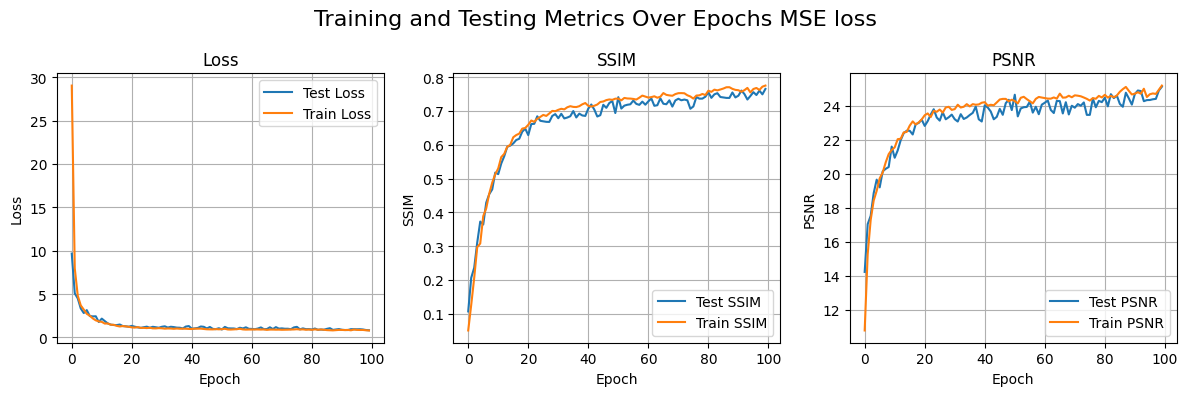

0.77
0.77


In [4]:
# print(test_mean_loss, train_mean_loss)

# Assuming test_mean_* lists exist
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Global title
fig.suptitle('Training and Testing Metrics Over Epochs MSE loss', fontsize=16)

# Loss Plot
axes[0].plot(test_mean_loss, label="Test Loss")
axes[0].plot(train_mean_loss, label="Train Loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

# SSIM Plot
axes[1].plot(test_mean_ssim, label="Test SSIM")
axes[1].plot(train_mean_ssim, label="Train SSIM")
axes[1].set_title('SSIM')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('SSIM')
axes[1].legend()
axes[1].grid()

# PSNR Plot
axes[2].plot(test_mean_psnr, label="Test PSNR")
axes[2].plot(train_mean_psnr, label="Train PSNR")
axes[2].set_title('PSNR')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('PSNR')
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()


print(f'{test_mean_ssim[-1]:.2f}')
print(f'{test_mean_ssim[-1]:.2f}')

## Model Testing & Evaluation
We verify the evolution of the model's performance with the number of 

### Performance

(3, 255, 255) (3, 255, 255)
(3, 255, 255) (3, 255, 255)
(3, 255, 255) (3, 255, 255)
(3, 288, 288) (3, 288, 288)
(3, 288, 288) (3, 288, 288)
(3, 288, 288) (3, 288, 288)
(3, 279, 279) (3, 279, 279)
(3, 279, 279) (3, 279, 279)
(3, 279, 279) (3, 279, 279)
(3, 510, 510) (3, 510, 510)
(3, 510, 510) (3, 510, 510)
(3, 510, 510) (3, 510, 510)
(3, 228, 342) (3, 228, 342)
(3, 228, 342) (3, 228, 342)
(3, 228, 342) (3, 228, 342)


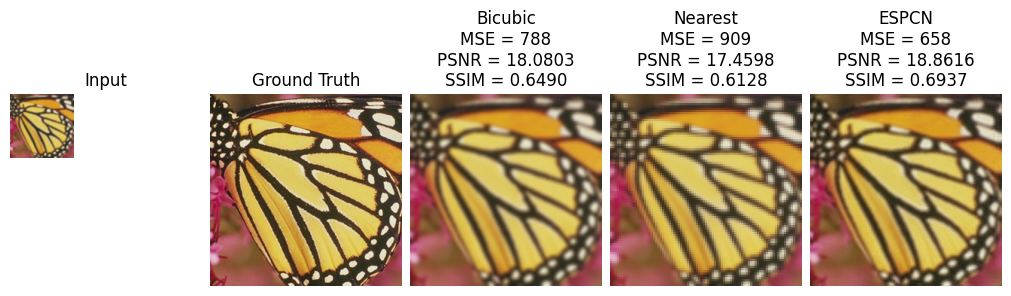

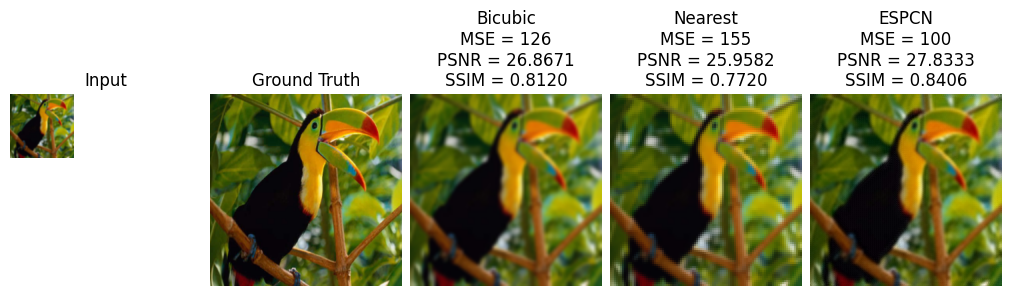

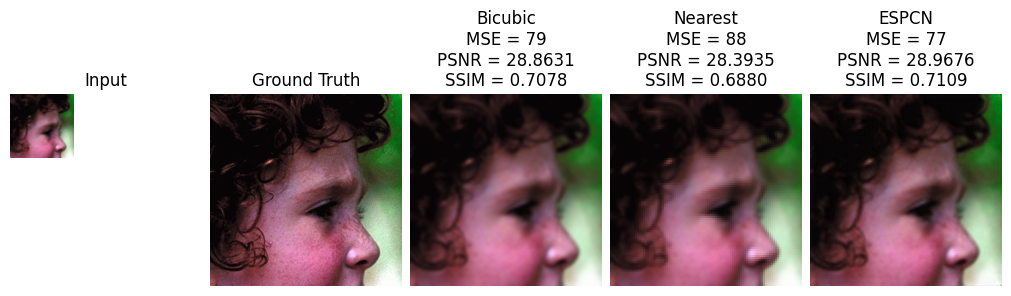

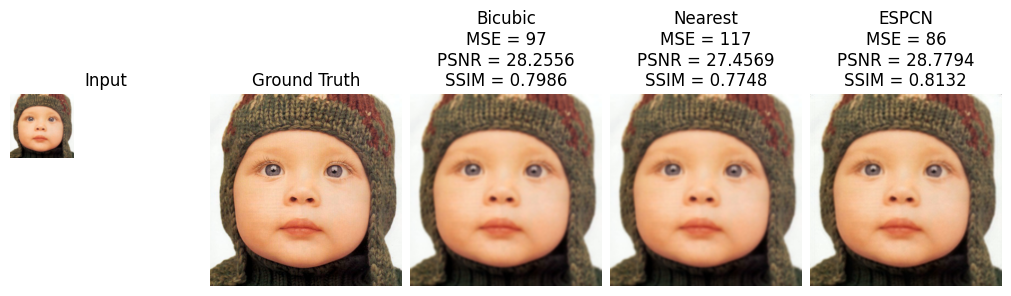

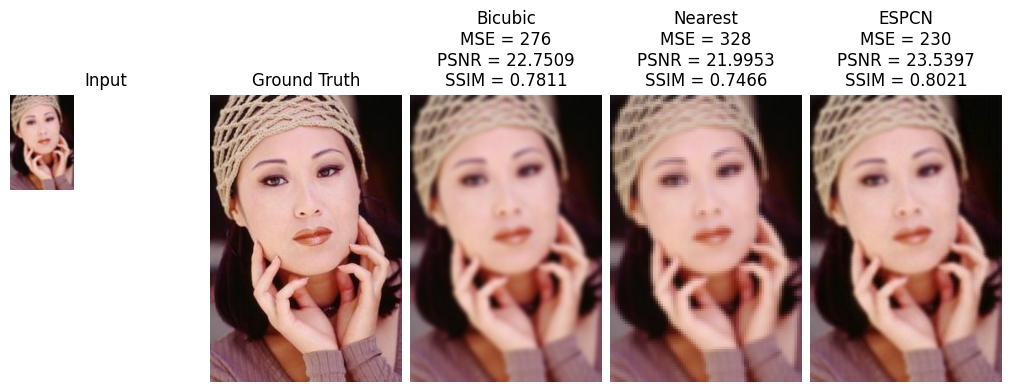

In [5]:
from supresolv.eval import eval_model

set5_path = "Images/Set5"
# images = os.listdir(set5_path)

images = [os.path.join(set5_path, img) for img in os.listdir(set5_path)]
x = eval_model(
    *images,
    upscale_factor=upscale_factor,
    model=f".models/model-100-ups-{upscale_factor:02d}-mse.pth",
)

for data in x:
    # print(data['espcn'])

    # print(data)
    fig, axs = plt.subplots(
        1, 5, figsize=(10, 4), constrained_layout=True, sharex=True, sharey=True
    )
    ax_iter = iter(axs)

    ax = next(ax_iter)
    ax.imshow(data["input"]["img"])
    ax.set_title("Input")

    ax = next(ax_iter)
    ax.imshow(data["target"]["img"])
    ax.set_title("Ground Truth")

    ax = next(ax_iter)
    ax.imshow(data["bicubic"]["img"])
    ax.set_title(
        "Bicubic\nMSE = {:.0f}\nPSNR = {:.4f}\nSSIM = {:.4f}".format(
            data["bicubic"]["mse"], data["bicubic"]["psnr"], data["bicubic"]["ssim"]
        )
    )

    ax = next(ax_iter)
    ax.imshow(data["nearest"]["img"])
    ax.set_title(
        "Nearest\nMSE = {:.0f}\nPSNR = {:.4f}\nSSIM = {:.4f}".format(
            data["nearest"]["mse"], data["nearest"]["psnr"], data["nearest"]["ssim"]
        )
    )

    ax = next(ax_iter)
    ax.imshow(data["espcn"]["img"])
    ax.set_title(
        "ESPCN\nMSE = {:.0f}\nPSNR = {:.4f}\nSSIM = {:.4f}".format(
            data["espcn"]["mse"], data["espcn"]["psnr"], data["espcn"]["ssim"]
        )
    )
    # ax = next(ax_iter)
    # x = data['nearest']
    # ax.imshow(data['nearest']['img'])
    # ax.set_title("Nearest\nMSE={:.3f}\nPSNR={:.3f}".format(x['mse'], x['psnr']))

    # ax = next(ax_iter)
    # ax.imshow(data['espcn'])
    # ax.set_title(f"ESPCN\n{psnr = :.4f}\n{mse = :.0f}")

    for ax in axs:
        ax.axis("off")  # remove the ticks

    # plt.show()

In [6]:
# upscale_factor = 3
# model = torch.load(
#     f".models/model-100-ups-{upscale_factor:02d}-mse.pth", weights_only=False
# )

# for input_image in images:
#     # img = os.path.join(set5_path, img)

#     x = load_img(input_image)
#     print(x.size)
#     crop_size_h, crop_size_v = list(
#         map(
#             lambda size: calculate_valid_crop_size(size, upscale_factor=upscale_factor),
#             x.size,
#         )
#     )

#     target = torchvision.transforms.functional.to_tensor(load_img(input_image))
#     target = torchvision.transforms.functional.center_crop(
#         target, (crop_size_h, crop_size_v)
#     )

#     img_original = PIL.Image.open(input_image).copy()
#     img_in = downsample_image(
#         input_image, out="tmp/my_downsampled_image.jpg", factor=upscale_factor
#     )
#     fp_in = "tmp/my_downsampled_image.jpg"

#     input_image, cb, cr = image_to_input(
#         img_in.convert("YCbCr")
#     )  # <-- somehow .convert("YCbCr") makes the result much better, must be a problem with reading from file
#     model.to("cpu")
#     out = model(input_image)
#     img_out = output_to_image(out, cb, cr)

#     psnr = peak_signal_noise_ratio(
#         target.view(crop_size_h, crop_size_v), out.view(crop_size_h, crop_size_v)
#     ).item()
#     mse = mean_squared_error(
#         target.view(crop_size_h, crop_size_v), out.view(crop_size_h, crop_size_v)
#     ).item()

#     img_bicubic = img_in.resize(img_out.size, PIL.Image.Resampling.BICUBIC)
#     img_nearest = img_in.resize(img_out.size, PIL.Image.Resampling.NEAREST)

#     img_out.save("tmp/asd.jpg")

#     fig, axs = plt.subplots(
#         1, 5, figsize=(14, 24), constrained_layout=True, sharex=True, sharey=True
#     )
#     ax_iter = iter(axs)

#     ax = next(ax_iter)
#     ax.imshow(img_in)
#     ax.set_title("Input")
#     ax = next(ax_iter)
#     ax.imshow(img_original)
#     ax.set_title("Ground Truth")

#     ax = next(ax_iter)
#     ax.imshow(img_bicubic)
#     ax.set_title("Bicubic")

#     ax = next(ax_iter)
#     ax.imshow(img_nearest)
#     ax.set_title("Nearest")

#     ax = next(ax_iter)
#     ax.imshow(img_out)
#     ax.set_title(f"ESPCN\n{psnr = :.4f}\n{mse = :.0f}")

#     for ax in axs:
#         ax.axis("off")  # remove the ticks

#     plt.show()

### Filters visualization

In [7]:
model: ESPCN = torch.load(".models/model-1400-ups-03-mse.pth", weights_only=False)
model.to("cpu")

# first layer filter
filters = model.conv1.weight.detach()

grid_size = len(filters)

fig, axes = plt.subplots(4, 16, figsize=(8, 2))

for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i][0].numpy(), cmap="gray")
    ax.axis("off")


plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '.models/model-1400-ups-03-mse.pth'

In [ ]:
# # second layer filter
# filters = model.conv2.weight.detach()

# grid_size = len(filters) 
# fig, axes = plt.subplots(4, 16, figsize=(8, 2))

# for i, ax in enumerate(axes.flat):
#     ax.imshow(filters[i][0].numpy(), cmap='gray')  
#     ax.axis('off') 


# plt.tight_layout()
# plt.show()